# Tests with Kronos for Forcasting


In [8]:
%pip install transformers torch einops

Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
import os
import torch
import pandas as pd 
import matplotlib.pyplot as plt

assert os.getcwd().endswith("ai_scratch"), "Please run this notebook from the ai_scratch directory."

PATH_PREFIX = "notebooks/kronos/"

# Ensure the kronos directory is in the Python path.
sys.path.append(os.getcwd() + f"/{PATH_PREFIX}")

from model import Kronos, KronosTokenizer, KronosPredictor

In [2]:
# Load from Hugging Face Hub
tokenizer = KronosTokenizer.from_pretrained("NeoQuasar/Kronos-Tokenizer-base")
model = Kronos.from_pretrained("NeoQuasar/Kronos-base")

In [3]:
# Instantiate Predictor

if torch.backends.mps.is_available():
    device = "mps"
    print("Using MPS")
elif torch.cuda.is_available():
    device = "cuda:0"
    print("Using CUDA")
else:
    device = "cpu"
    print("Using CPU")

predictor = KronosPredictor(model, tokenizer, device=device, max_context=512)

Using MPS


In [4]:
def plot_prediction(kline_df, pred_df):
    pred_df.index = kline_df.index[-pred_df.shape[0]:]
    sr_close = kline_df['close']
    sr_pred_close = pred_df['close']
    sr_close.name = 'Ground Truth'
    sr_pred_close.name = "Prediction"

    sr_volume = kline_df['volume']
    sr_pred_volume = pred_df['volume']
    sr_volume.name = 'Ground Truth'
    sr_pred_volume.name = "Prediction"

    close_df = pd.concat([sr_close, sr_pred_close], axis=1)
    volume_df = pd.concat([sr_volume, sr_pred_volume], axis=1)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    ax1.plot(close_df['Ground Truth'], label='Ground Truth', color='blue', linewidth=1.5)
    ax1.plot(close_df['Prediction'], label='Prediction', color='red', linewidth=1.5)
    ax1.set_ylabel('Close Price', fontsize=14)
    ax1.legend(loc='lower left', fontsize=12)
    ax1.grid(True)

    ax2.plot(volume_df['Ground Truth'], label='Ground Truth', color='blue', linewidth=1.5)
    ax2.plot(volume_df['Prediction'], label='Prediction', color='red', linewidth=1.5)
    ax2.set_ylabel('Volume', fontsize=14)
    ax2.legend(loc='upper left', fontsize=12)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

## Check the dataframe slicing logic

In [ ]:
import numpy as np

# Generate a DataFrame with 20 rows and columns 'x' and 'y' with random numeric values
df = pd.DataFrame({
    'x': np.random.rand(20),
    'y': np.random.rand(20)
})

print(f"{df=}")

last_n = 10
# Take the first `lookback` rows for x and the next `pred_len` rows for y.
lookback = 5
pred_len = 5

assert lookback <= df.shape[0], "Lookback exceeds DataFrame length."

# Only keep the last `last_n` rows.
df = df.tail(last_n)

x_df = df.iloc[:lookback][['x']]
x_timestamp = df.iloc[:lookback]['x']
y_timestamp = df.iloc[lookback:lookback+pred_len]['y']

print(f"{x_df=}")
print("\n---\n")

print(f"{x_timestamp=}")
print("\n---\n")

print(f"{y_timestamp=}")

df=           x         y
0   0.289873  0.464133
1   0.369512  0.248657
2   0.246057  0.968539
3   0.311333  0.771920
4   0.382138  0.413173
5   0.474997  0.033264
6   0.677334  0.419873
7   0.753574  0.717601
8   0.940465  0.030283
9   0.496752  0.126380
10  0.931520  0.612290
11  0.704918  0.744588
12  0.614611  0.937100
13  0.984709  0.479899
14  0.276255  0.142553
15  0.372469  0.183385
16  0.213544  0.335233
17  0.723015  0.473686
18  0.918424  0.366774
19  0.482215  0.684099
x_df=           x
10  0.931520
11  0.704918
12  0.614611
13  0.984709
14  0.276255

---

x_timestamp=10    0.931520
11    0.704918
12    0.614611
13    0.984709
14    0.276255
Name: x, dtype: float64

---

y_timestamp=15    0.183385
16    0.335233
17    0.473686
18    0.366774
19    0.684099
Name: y, dtype: float64


## Try with sample data

In [5]:
def load_sample_data():
    df = pd.read_csv("notebooks/kronos/examples/data/XSHG_5min_600977.csv")
    df['timestamps'] = pd.to_datetime(df['timestamps'])
    return df

df = load_sample_data()

last_n = 600
lookback = 400
pred_len = 120

assert lookback <= df.shape[0], "Lookback exceeds DataFrame length."

df = df.tail(last_n)

x_df = df.iloc[:lookback][['open', 'high', 'low', 'close', 'volume', 'amount']]
x_timestamp = df.iloc[:lookback]['timestamps']
y_timestamp = df.iloc[lookback:lookback+pred_len]['timestamps']

In [43]:
x_df

,open,high,low,close,volume,amount
1900,10.58,10.67,10.54,10.54,2531.0,2677092.0
1901,10.54,10.55,10.51,10.51,2335.0,2458889.0
1902,10.52,10.55,10.49,10.54,3952.0,4152949.0
1903,10.55,10.56,10.48,10.48,1717.0,1804275.0
1904,10.49,10.51,10.47,10.48,1913.0,2006734.0
...,...,...,...,...,...,...
2295,9.81,9.81,9.80,9.80,419.0,410959.0
2296,9.80,9.82,9.79,9.80,1118.0,1095862.0
2297,9.81,9.84,9.81,9.82,476.0,467581.0
2298,9.82,9.83,9.81,9.81,382.0,375004.0


In [44]:
x_timestamp

1900   2024-08-13 09:35:00
1901   2024-08-13 09:40:00
1902   2024-08-13 09:45:00
1903   2024-08-13 09:50:00
1904   2024-08-13 09:55:00
               ...        
2295   2024-08-23 10:30:00
2296   2024-08-23 10:35:00
2297   2024-08-23 10:40:00
2298   2024-08-23 10:45:00
2299   2024-08-23 10:50:00
Name: timestamps, Length: 400, dtype: datetime64[ns]

In [45]:
y_timestamp

2300   2024-08-23 10:55:00
2301   2024-08-23 11:00:00
2302   2024-08-23 11:05:00
2303   2024-08-23 11:10:00
2304   2024-08-23 11:15:00
               ...        
2415   2024-08-27 14:00:00
2416   2024-08-27 14:05:00
2417   2024-08-27 14:10:00
2418   2024-08-27 14:15:00
2419   2024-08-27 14:20:00
Name: timestamps, Length: 120, dtype: datetime64[ns]

In [6]:
# 4. Make Prediction
pred_df = predictor.predict(
    df=x_df,
    x_timestamp=x_timestamp,
    y_timestamp=y_timestamp,
    pred_len=pred_len,
    T=1.0,
    top_p=0.9,
    sample_count=1,
    verbose=True
)

# 5. Visualize Results
print("Forecasted Data Head:")
print(pred_df.head())


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:17<00:00,  6.79it/s]


Forecasted Data Head:
                         open      high       low     close       volume  \
timestamps                                                                 
2024-08-23 10:55:00  9.852103  9.849220  9.838914  9.838638   500.018860   
2024-08-23 11:00:00  9.845674  9.844683  9.828969  9.831113   906.495605   
2024-08-23 11:05:00  9.838116  9.838417  9.822744  9.826231   961.168213   
2024-08-23 11:10:00  9.834408  9.835256  9.820487  9.823997  1378.661499   
2024-08-23 11:15:00  9.824755  9.831302  9.821065  9.828374   367.987915   

                           amount  
timestamps                         
2024-08-23 10:55:00  5.167821e+05  
2024-08-23 11:00:00  8.944084e+05  
2024-08-23 11:05:00  9.440892e+05  
2024-08-23 11:10:00  1.330155e+06  
2024-08-23 11:15:00  3.735356e+05  


Visually compare the predicted close prices

In [ ]:
def get_pred_vs_actual(pred_df, actual_df, colname):
    pred_vs_actual_df = pd.DataFrame({
        'actual': actual_df[colname],
        'pred': pred_df[colname],
        'diff_pred_vs_actual': pred_df[colname] - actual_df[colname]
    })

    return(pred_vs_actual_df)

get_pred_vs_actual(pred_df, df.iloc[lookback:lookback+pred_len], 'close')

,actual_close,pred_close,diff_pred_vs_actual
2300,9.81,9.838638,0.028638
2301,9.80,9.831113,0.031113
2302,9.81,9.826231,0.016231
2303,9.83,9.823997,-0.006003
2304,9.85,9.828374,-0.021626
...,...,...,...
2415,9.67,10.400594,0.730594
2416,9.67,10.423718,0.753718
2417,9.67,10.426807,0.756807
2418,9.66,10.426149,0.766149


In [8]:
pred_df['close']

2300     9.838638
2301     9.831113
2302     9.826231
2303     9.823997
2304     9.828374
          ...    
2415    10.400594
2416    10.423718
2417    10.426807
2418    10.426149
2419    10.432478
Name: Prediction, Length: 120, dtype: float32

In [ ]:
df.iloc[lookback:lookback+pred_len]

,timestamps,open,high,low,close,volume,amount
2300,2024-08-23 10:55:00,9.82,9.82,9.80,9.81,328.0,321782.0
2301,2024-08-23 11:00:00,9.82,9.82,9.80,9.80,920.0,902202.0
2302,2024-08-23 11:05:00,9.80,9.83,9.79,9.81,317.0,310991.0
2303,2024-08-23 11:10:00,9.82,9.85,9.81,9.83,543.0,534054.0
2304,2024-08-23 11:15:00,9.83,9.86,9.83,9.85,424.0,417600.0
...,...,...,...,...,...,...,...
2415,2024-08-27 14:00:00,9.66,9.67,9.65,9.67,1308.0,1263960.0
2416,2024-08-27 14:05:00,9.66,9.67,9.66,9.67,399.0,385695.0
2417,2024-08-27 14:10:00,9.66,9.67,9.66,9.67,233.0,225118.0
2418,2024-08-27 14:15:00,9.67,9.67,9.65,9.66,1214.0,1172290.0


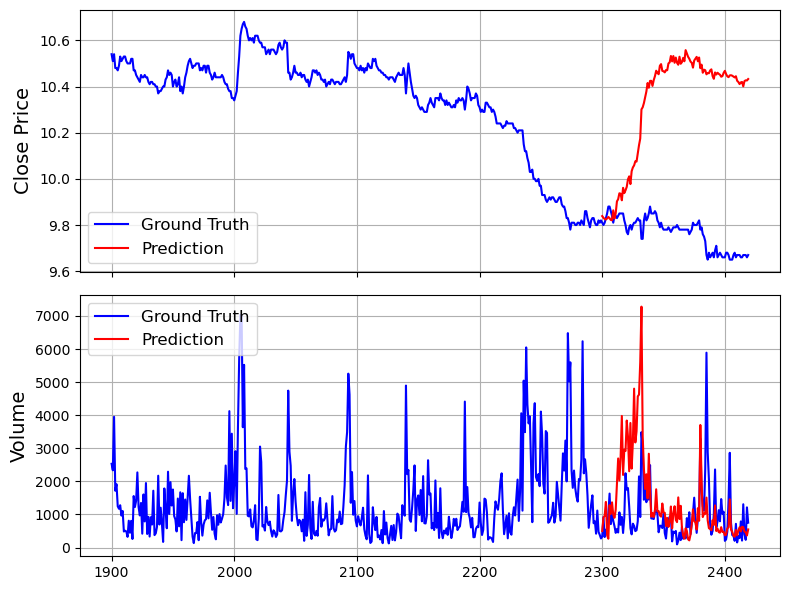

In [7]:
# Combine historical and forecasted data for plotting
kline_df = df.iloc[:lookback+pred_len]

# visualize
plot_prediction(kline_df, pred_df)

## Now with BTC real data

In [69]:
def load_btc_data():
    df = pd.read_csv(f"{PATH_PREFIX}/data/bitcoin_historical_data.csv")
    
    return df
df = load_btc_data()

df

,timestamps,open,high,low,close,volume,amount
0,2025-10-10,121662.41,122550.00,102000.00,112774.50,64171.93927,7.349751e+09
1,2025-10-11,112774.49,113322.39,109561.59,110644.40,35448.51652,3.961069e+09
2,2025-10-12,110644.40,115770.00,109565.06,114958.80,32255.30272,3.638547e+09
3,2025-10-13,114958.81,115963.81,113616.50,115166.00,22557.24033,2.591832e+09
4,2025-10-14,115166.00,115409.96,109866.00,113028.14,31870.32974,3.578141e+09
5,2025-10-15,113028.13,113612.35,110164.00,110763.28,22986.48811,2.569640e+09
6,2025-10-16,110763.28,111982.45,107427.00,108194.28,29857.17252,3.277596e+09
7,2025-10-17,108194.27,109240.00,103528.23,106431.68,37920.66838,4.022646e+09
8,2025-10-18,106431.68,107499.00,106322.20,106786.22,10027.55918,1.071704e+09


In [55]:
# Specify the number of input rows to use.
last_n_rows = 20

# Specify the prediction length.
pred_len = 5


input_data = df.iloc[-(last_n_rows):]

In [56]:
input_data

,timestamp,open,high,low,close,volume
7235658,2025-10-04 23:39:00,122364.0,122366.0,122364.0,122366.0,0.018122
7235659,2025-10-04 23:40:00,122366.0,122374.0,122366.0,122373.0,0.136368
7235660,2025-10-04 23:41:00,122373.0,122384.0,122373.0,122384.0,0.060269
7235661,2025-10-04 23:42:00,122384.0,122384.0,122384.0,122384.0,0.011062
7235662,2025-10-04 23:43:00,122384.0,122384.0,122384.0,122384.0,0.011345
7235663,2025-10-04 23:44:00,122384.0,122384.0,122384.0,122384.0,0.022164
7235664,2025-10-04 23:45:00,122384.0,122458.0,122384.0,122457.0,6.225230
7235665,2025-10-04 23:46:00,122457.0,122458.0,122402.0,122458.0,0.476123
7235666,2025-10-04 23:47:00,122458.0,122472.0,122458.0,122462.0,0.789578
7235667,2025-10-04 23:48:00,122462.0,122462.0,122462.0,122462.0,0.500000


In [57]:
x_timestamp = df.iloc[-(last_n_rows):]['timestamp']

In [58]:
x_timestamp

7235658   2025-10-04 23:39:00
7235659   2025-10-04 23:40:00
7235660   2025-10-04 23:41:00
7235661   2025-10-04 23:42:00
7235662   2025-10-04 23:43:00
7235663   2025-10-04 23:44:00
7235664   2025-10-04 23:45:00
7235665   2025-10-04 23:46:00
7235666   2025-10-04 23:47:00
7235667   2025-10-04 23:48:00
7235668   2025-10-04 23:49:00
7235669   2025-10-04 23:50:00
7235670   2025-10-04 23:51:00
7235671   2025-10-04 23:52:00
7235672   2025-10-04 23:53:00
7235673   2025-10-04 23:54:00
7235674   2025-10-04 23:55:00
7235675   2025-10-04 23:56:00
7235676   2025-10-04 23:57:00
7235677   2025-10-04 23:58:00
Name: timestamp, dtype: datetime64[ns]

In [59]:
y_timestamp = df.iloc[-(last_n_rows - pred_len + 1):]['timestamp']

In [60]:
y_timestamp

7235662   2025-10-04 23:43:00
7235663   2025-10-04 23:44:00
7235664   2025-10-04 23:45:00
7235665   2025-10-04 23:46:00
7235666   2025-10-04 23:47:00
7235667   2025-10-04 23:48:00
7235668   2025-10-04 23:49:00
7235669   2025-10-04 23:50:00
7235670   2025-10-04 23:51:00
7235671   2025-10-04 23:52:00
7235672   2025-10-04 23:53:00
7235673   2025-10-04 23:54:00
7235674   2025-10-04 23:55:00
7235675   2025-10-04 23:56:00
7235676   2025-10-04 23:57:00
7235677   2025-10-04 23:58:00
Name: timestamp, dtype: datetime64[ns]

In [ ]:
lookback = 5
pred_len = 3

assert lookback <= df.shape[0], "Lookback exceeds DataFrame length."

x_df = df.iloc[:lookback][['open', 'high', 'low', 'close', 'volume', 'amount']]
x_timestamp = df.iloc[:lookback]['timestamps']
y_timestamp = df.iloc[lookback:lookback+pred_len]['timestamps']